In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [18]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

In [19]:


g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) / (n_embd * block_size)**(0.5)
b1 = torch.randn(n_hidden,                        generator=g) *0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g)

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [279]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = (embcat @ W1 + b1)  # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi =  hpreact.std(0, keepdim =True)
    hpreact = bngain*((hpreact - bnmeani) / bnstdi) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
        
    hpreact.retain_grad()
    logits.retain_grad()
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())



      0/ 200000: 3.7972
  10000/ 200000: 2.1438
  20000/ 200000: 2.3134
  30000/ 200000: 2.4173
  40000/ 200000: 2.0318
  50000/ 200000: 2.3322
  60000/ 200000: 2.3562
  70000/ 200000: 2.1275
  80000/ 200000: 2.4341
  90000/ 200000: 2.1366
 100000/ 200000: 1.8885
 110000/ 200000: 2.3546
 120000/ 200000: 2.0248
 130000/ 200000: 2.4184
 140000/ 200000: 2.3339
 150000/ 200000: 2.2531
 160000/ 200000: 1.9941
 170000/ 200000: 1.9306
 180000/ 200000: 2.0982
 190000/ 200000: 1.9399


In [269]:
bnmean_running.sum()

tensor(28.2008)

In [ ]:
# forward pass
emb = C[Xtrn] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer
hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

# Non-linearity
h = torch.tanh(hpreact) # hidden layer
logits = h @ W2 + b2 # output layer
loss = F.cross_entropy(logits, Ydev) # loss function

loss

In [271]:
# forward pass
emb = C[Xtr] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer
hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
bnmeangg = hpreact.mean(0)
bnstdgg = hpreact.std(0)
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
logits = h @ W2 + b2 # output layer
loss = F.cross_entropy(logits, Ytr) # loss function

loss

tensor(3.1850, grad_fn=<NllLossBackward0>)

In [273]:
bnmeangg.sum()

tensor(28.2016, grad_fn=<SumBackward0>)

### Loss on dev set

In [266]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
#     emb = C[x]  # (N, block_size, n_embd)
#     x = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
#     for layer in layers:
#         x = layer(x)
#     loss = F.cross_entropy(x, y)
#     print(split, loss.item())
    
    emb = C[x] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split,loss)


split_loss("train")
split_loss("val")


train tensor(3.1850)
val tensor(3.2144)


## weight initialization

x mean and std tensor(0.0030) tensor(0.9986)
y mean and std tensor(0.0011) tensor(3.1332)


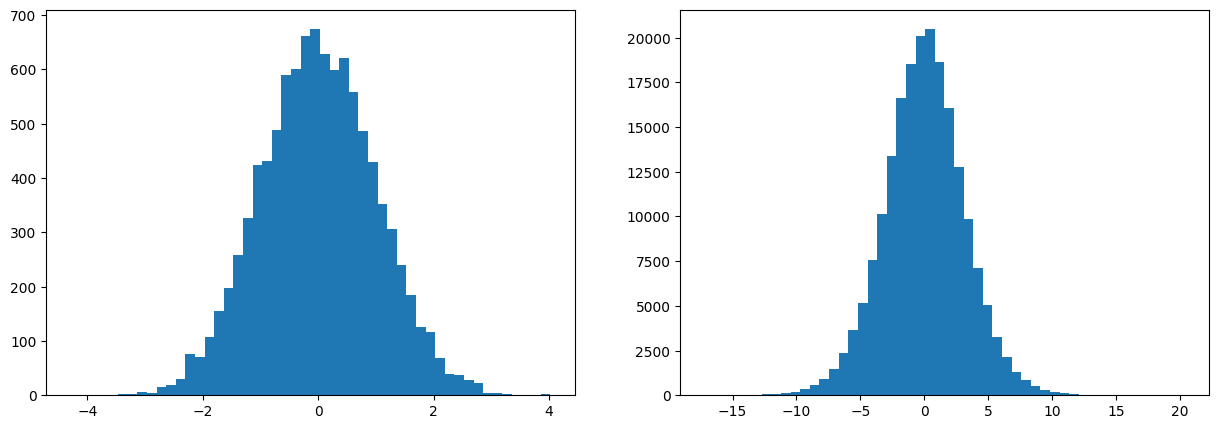

In [244]:
x = torch.randn(1000,10)
w = torch.randn(10, 200)
y = x @ w

print('x mean and std', x.mean(), x.std())
print('y mean and std', y.mean(), y.std())

plt.figure(figsize= (15,5))
plt.subplot(121)
plt.hist(x.flatten().detach(), bins = 50)
plt.subplot(122)
plt.hist(y.flatten().detach(), bins = 50)
plt.show()

In [333]:
x = torch.randn(32, 30, generator = g)
w = torch.randn(30, 100, generator = g) / (30)**(0.5)
b = torch.randn(100, generator = g)

y = x@w + b

In [334]:
y

tensor([[-2.1859,  1.3968,  0.9440,  ...,  0.5572, -0.9285,  1.1951],
        [-2.5453, -0.2407,  1.5838,  ...,  0.5677,  0.9325,  0.1427],
        [-2.1432, -1.5575,  2.8792,  ...,  0.6169, -0.1623,  1.5904],
        ...,
        [-0.9542,  0.1352,  2.0258,  ..., -0.2528,  0.2054,  2.0338],
        [-2.0087,  1.4935,  2.2742,  ...,  1.3092,  0.1228,  1.8301],
        [-0.5738, -2.5842,  0.5256,  ...,  0.4121, -1.3940,  2.7067]])

### Pytorchifying this NN


In [84]:
# Linear Layer
g = torch.Generator().manual_seed(2147483647) # for reproducibility


class Layer:
    def __init__(self,fan_in, fan_out, bias=False):
        self.w = torch.randn((fan_in, fan_out),generator = g) #/ (fan_in)**(0.5) # applying kaiming init
        self.bias = bias
        if bias:
            self.b = torch.zeros(fan_out)
            
    def __call__(self, x):
        y = x @ self.w
        self.out = y + self.b if self.bias else y
        return self.out
    

    def parameters(self):
        
        return [self.w] + [self.b] if self.bias else [self.w]
    
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    



In [95]:
class BatchNormalization1:
    def __init__(self,nf, eps= 1e-5, mom=0.1):
        self.bngain = torch.ones(nf)
        self.bnbias = torch.zeros(nf)
        self.out = None
        self.mom = mom
        self.training = True
        self.running_mean = torch.ones(nf)
        self.running_var = torch.zeros(nf)
        self.eps = eps
    
    def __call__(self,x):
        
        if self.training:
            meani = x.mean(0, keepdim = True)
            vari = x.var(0, keepdim = True)
            
        else:
            meani = self.running_mean
            vari = self.running_var
            
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.mom)*self.running_mean + self.mom*meani
                self.running_var = (1-self.mom)*self.running_var + self.mom*vari

        self.out = self.bngain *((x - meani)/ torch.sqrt(vari + self.eps)) + self.bnbias

        return self.out
    
    def parameters(self):
        return [self.bngain, self.bnbias]

### structure for our NN

In [98]:
import torch.nn.functional as F


x = torch.randn(32, 30, generator = g)
y = torch.tensor([random.randint(0,26) for _ in range(32)] )

# Embedding layer,
n_embd = 10
n_vocab = 27
n_dim = 100
batch_size = 32
C = torch.randn((n_vocab,n_embd))


st = [
    # x shape = 32, 30
    Layer(n_embd*block_size,n_dim), BatchNormalization1(n_dim), Tanh(), 
    Layer(n_dim, n_dim), BatchNormalization1(n_dim), Tanh(),
    Layer(n_dim, n_dim), BatchNormalization1(n_dim), Tanh(),
    Layer(n_dim, n_dim), BatchNormalization1(n_dim), Tanh(),
    Layer(n_dim, n_dim), BatchNormalization1(n_dim), Tanh(),
    Layer(n_dim, n_vocab),BatchNormalization1(n_vocab)
]

# st = [
#     # x shape = 32, 30
#     Layer(n_embd*block_size,n_dim), Tanh(), 
#     Layer(n_dim, n_dim), Tanh(),
#     Layer(n_dim, n_dim) , Tanh(),
#     Layer(n_dim, n_dim), Tanh(),
#     Layer(n_dim, n_dim), Tanh(),
#     Layer(n_dim, n_vocab),BatchNormalization1(n_vocab)
# ]


with torch.no_grad():
    st[-1].bngain *= 0.1
    
    for layer in st[:-1]:
        if isinstance(layer, Layer):
            layer.w *= 1



parameters = [C] + [p for l in st for p in l.parameters()]
for p in parameters:
    p.requires_grad = True

In [99]:

        
for iteration in range(200000):
    
    # for iteration in range(2000):
    idx = torch.randint(0,Xtr.shape[0], (batch_size,))
    x_emb = C[Xtr[idx]].view(-1, block_size * n_embd)
    x = x_emb
    for idx,item in enumerate(st):
#         print(idx)
        x = item(x)

    loss = F.cross_entropy(x,y)
    
    for layer in st:
        layer.out.retain_grad() 
        
    for p in parameters:
        p.grad = None

    loss.backward()
    
    lr = 0.1 if iteration < 150000 else 0.01
    for p in parameters:

        p.data += -lr*p.grad
    
    if iteration % 10000 ==0:
        print(loss.data)

    if iteration >= 10000:
        break

tensor(3.2993)
tensor(2.5685)


### distrubtion when gain of 5/3 is applied to the weights, before tanh

### initial iteration

mean 0.004258470144122839 and std 0.6379491090774536, saturation tensor(2.8750)
mean 0.0013203242560848594 and std 0.6335046291351318, saturation tensor(2.9375)
mean -0.0045478735119104385 and std 0.6361764073371887, saturation tensor(2.8438)
mean -0.0009722389513626695 and std 0.6362013220787048, saturation tensor(2.7188)
mean -0.008134252391755581 and std 0.6327334642410278, saturation tensor(2.6875)


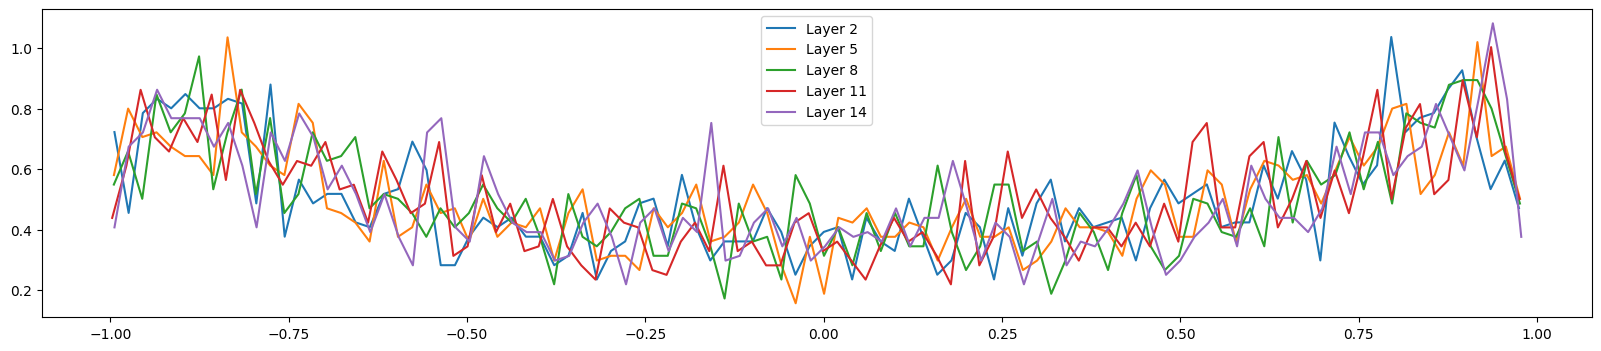

In [100]:
plt.figure(figsize=(20, 4)) 
legends = []
for idx, layer in enumerate(st):
    if isinstance(layer,Tanh):
        val = layer.out
        mean = val.mean()
        std = val.std()
        
        print(f'mean {mean} and std {std}, saturation', ( abs(val) > 0.97).float().mean()*100 )
        hy,hx = torch.histogram(val, density = True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'Layer {idx}')
        
plt.legend(legends)
plt.show()
        
        

### distrubtion when no gain is applied to the weights, before tanh

mean -2.0372681406449766e-12 and std 0.00029811926651746035, saturation tensor(0.)
mean 1.2369128074216085e-12 and std 0.0002446519210934639, saturation tensor(0.)
mean -1.45519149031062e-13 and std 0.0002205681084888056, saturation tensor(0.)
mean -1.45519149031062e-13 and std 0.0001879719493445009, saturation tensor(0.)
mean 1.8189894306509108e-13 and std 0.00017754653526935726, saturation tensor(0.)


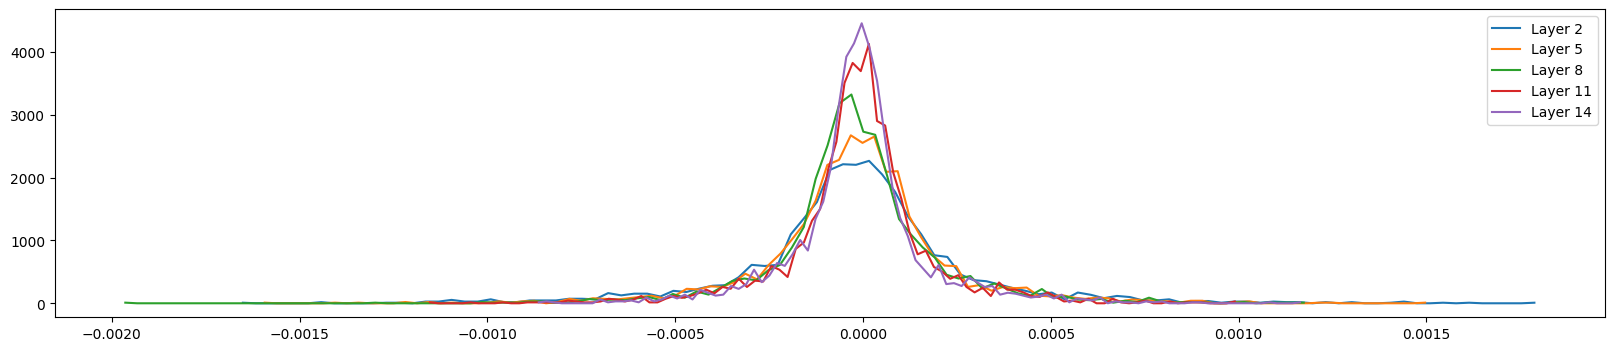

In [101]:
plt.figure(figsize=(20, 4)) 
legends = []
for idx, layer in enumerate(st):
    if isinstance(layer,Tanh):
        val = layer.out.grad
        mean = val.mean()
        std = val.std()
        
        print(f'mean {mean} and std {std}, saturation', ( abs(val) > 0.97).float().mean()*100 )
        hy,hx = torch.histogram(val, density = True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'Layer {idx}')
        
plt.legend(legends)
plt.show()
        
        